# 6a. Assessed Practical

## 6.1 Introduction

### 6.1.1 Site, Data and Task overview

These notes describe the practical you must submit for assessment in this course.

The practical comes in two parts: (1) data preparation; (2) modelling. 

It is important that you complete both parts of this exercise, as you will need to make use of the code and results in the work you submit for assessment for this course.

- **Data Preparation**
  
     The first task you must complete is to produce a dataset of the proportion of HUC catchment 13010001 (Rio Grande headwaters in Colorado, USA) that is covered by snow for **two consecutive years**, along with associated datasets on temperature (in C) and river discharge at the Del Norte monitoring station. You **may not** use data from the year 2005, as this is given to you in the illustrations above.

    The dataset you produce must have a value for the mean snow cover, temperature and discharge in the catchment for every day over each year.

    Your write up **must** include fully labelled graph(s) of snow cover, temperature and discharge for the catchment for each year (with units as appropriate), along with some summary statistics (e.g. mean or median, minimum, maximum, and the timing of these). 
    
    You **must** provide evidence of how you got these data (i.e. the code and commands you ran to produce the data).
    
    
    
- **Modelling**

    You will have prepared two years of data above. Use one of these years to calibrate the (snowmelt) hydrological model (described below) and one year to test it. 
    
    The model parameter estimate *must* be objective (i.e. you can't just arbitrarily choose a set) and ideally optimal, and you *must* state the equation of the cost function you will try to minimise and explain the approach used.
    
    You **must** state the values of the model parameters that you have estimated and show evidence for how you went about calculating them. Ideally, you should also state the uncertainty in these parameter estimates (not critical to pass this section though).
    
    You **must** quantify the goodness of fit between your measured flow data and that produced by your model, booth for the calibration exercise and the validation.
    

You **must** work individually on this task. If you do not, it will be treated as plagiarism. By reading these instructions for this exercise, we assume that you are aware of the UCL rules on plagiarism. You can find more information on this matter in your student handbook. If in doubt about what might constitute plagiarism, ask one of the course convenors.

What you are going to do is to build, calibrate and test a (snowmelt) hydrological model, driven by observations in the Rio Grande Headwaters in Colorado, USA. 

**You will need to process two years of data (N.B. *not* 2005 as that is given in the illustrations).**

The purpose of the model is to describe the streamflow at the Del Norte measurement station, just on the edge of the catchment.

The average climate for Del Norte is:

![](files/images/usco0103climatedelnorte.png)

Further general information is available from various [websites](http://www.usclimatedata.com/climate.php?location=USCO0103), including [NOAA](http://www4.ncdc.noaa.gov/cgi-win/wwcgi.dll?wwDI~StnSrch~StnID~10100138).

You can visualise the site [here](http://mesonet.agron.iastate.edu/sites/site.php?station=CO2184&network=COCLIMATE).

First then, we should look at the streamflow data. These data are in the file [delnorte.dat](files/data/delnorte.dat) for the years 2000 to 2010 inclusive. You can get further data from [ http://waterdata.usgs.gov](http://waterdata.usgs.gov) if you wish.



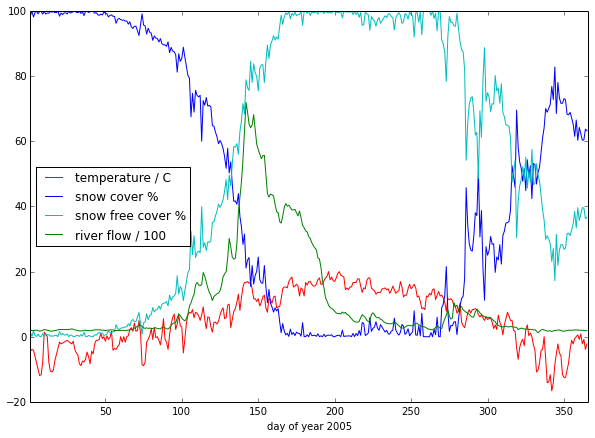

In [2]:
# load a pre-cooked version of the data for 2005 (NB -- Dont use this year!!!
# except perhaps for testing)

# load the data from a pickle file
import pickle
pkl_file = open('data/data.pkl', 'rb')
data = pickle.load(pkl_file)
pkl_file.close()

# set up plot
plt.figure(figsize=(10,7))
plt.xlim(data['doy'][0],data['doy'][-1]+1)
plt.xlabel('day of year 2005')

# plot data
plt.plot(data['doy'],data['temp'],'r',label='temperature / C')
plt.plot(data['doy'],data['snowprop']*100,'b',label='snow cover %')
plt.plot(data['doy'],100-data['snowprop']*100,'c',label='snow free cover %')
plt.plot(data['doy'],data['flow']/100.,'g',label='river flow / 100')


plt.legend(loc='best')

we have plotted the streamflow (scaled) in green, the snow cover in blue, and the non snow cover in cyan and the temperature in red. It should be apparent that thge hydrology is snow melt dominated, and to describe this (i.e. to build the simplest possible model) we can probably just apply some time lag function to the snow cover.

### 6.1.2 The Model

We will build a mass balance model, in terms of 'snow water equivalent':

The basis of a model is going to be something of the form:

$$
SWE = k * snowProportion
$$

where $SWE$ is the 'snow water equivalent', the amount of snow in the entire snow pack in the catchment. $snowProportion$ here then, is the proportion of snow cover in the catchment. We lump together density and volume terms into the coefficient $k$. 

$SWE$ then is the 'mass' (of water) that is available for melting on a particular day. We can obtain $snowProportion$ from satellite data, so we only need the area / density term $k$, which we can suppose to be constant over time.

The simplest model of snowmelt is one where we assume that a proportion of this $SWE$ is released (melted) as a function of temperature. In its simplest form, this is simply a temperature threshold:

``
meltDays = np.where(temperature > tempThresh)[0]
``

On these melt days then, we add `k * snowProportion` of water into the system. For the present, we will ignore direct precipitation. So:

``
for d in meltDays:
    water = K * snowProportion[d]
``

Now we have a mechanism to release snow melt into the catchment, but there will always be some delay in the water reaching the monitoring station from far away regions, compared to nearby areas. The function that describes this delay can be called a network response function. It is often modelled as a Laplace function (an exponential). The idea is that if we have a 'flash' input to the catchment, this [network response function](http://www.google.co.uk/search?q=network+response+function&ie=utf-8&oe=utf-8&aq=t&rls=org.mozilla:en-US:official&client=firefox-a#sclient=psy-ab&hl=en&client=firefox-a&hs=qgI&rls=org.mozilla:en-US%3Aofficial&source=hp&q=network+response+function+hydrology&pbx=1&oq=network+response+function+hydrology&aq=f&aqi=&aql=&gs_sm=e&gs_upl=2213l4483l0l4547l10l9l0l0l0l0l226l961l6.2.1l9l0&bav=on.2,or.r_gc.r_pw.r_cp.,cf.osb&fp=d48ede2c1f2a6462&biw=1098&bih=673) will give us what we would measure as a hydrograph at the monitoring station (or elsewhere).

We can parameterise this with a decay factor, p, so that if the amount of water on day d is 1, the amount on day d+1 is p, on d+2, p^2 etc:

``
n = np.arange(len(snowProportion)) - d
m = p ** n
m[np.where(n<0)]=0
``

so here, `m` is the decay function:

![](files/images/laplace.png)

for day 150. This model will transfer a large amount of water of the peak day, then less and less as time goes by. So, a simple model then is of the form:

In [3]:
def model_accum(data,tempThresh,k,p):
    meltDays = np.where(data['temp'] > tempThresh)[0]
    accum = data['snowprop']*0.
    for d in meltDays:
        water = k * data['snowprop'][d]
        n = np.arange(len(data['snowprop'])) - d
        m = p ** n
        m[np.where(n<0)]=0
        accum += m * water
    return accum


tempThresh = 8.5
k = 2000.0
p = 0.95

# test it
accum = model_accum(data,tempThresh,k,p)

This is a very simple model. It has three parameters (`tempThresh`, `k`, `p`) and is driven only by temperature and snow cover data. And yet, we see that even with a rough guess at what the parameters ought to be, we can get a reasonable match with the observed flow data:

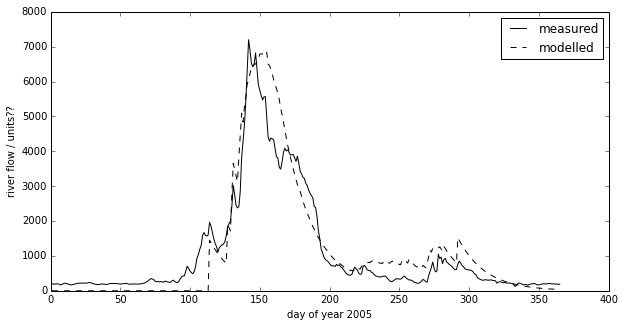

In [4]:
plt.figure(figsize=(10,5))
plt.plot(data['doy'],data['flow'],'k',label='measured')
plt.plot(data['doy'],accum,'k--',label='modelled')
plt.ylabel('river flow / units??')
plt.xlabel('day of year 2005')
plt.legend(loc='best')

## 6.2 Data Preparation

### 6.2.1 Statement of the task

The first task you must complete is to produce a dataset of the proportion of HUC catchment 13010001 (Rio Grande headwaters) that is covered by snow for **two years**, along with associated datasets on temperature and river discharge at the Del Norte monitoring station.

The dataset you produce must have a value for the mean snow cover, temperature and discharge in the catchment for every day over each year.

Your write up **must** include a fully labelled graph of snow cover, temperature and discharge for the catchment for each year, along with some summary statistics (e.g. mean or median, minimum, maximum, and the timing of these).

![](files/images/snow.png)

You should aim to complete this task soon after Reading Week. 

### 6.2.2 Some Advice

You would probably want to use a **daily** snow product for this task, such as that available from MODIS, so make sure you know what that is and explore the characteristics of the dataset.
  
You will notice from the figure above (the figure should give you some clue as to a suitable data product) that there will be areas of each image for which you have no information (described in the dataset QC). You will need to decide what to do about 'missing data'. For instance, you might consider interpolating over missing values. 

The simplest thing might be to produce a mean snow cover over what samples are available (ignoring the missing values). But whilst that may be sufficient to pass this section, it is far from ideal. 

Whilst you only need to produce an average daily value for the catchment, a better approach would be to try to estimate snow cover for each pixel in the catchment (e.g. so you could do spatially explicit modelling with such data). I stress that this is not strictly necessary, but would be an interesting thing to do if you feel able.

However you decide to process the data, you must give a rationale for why you have taken the approach you have done. 

You will notice that if you use MODIS data, you have access to both data from Terra (MOD10A) and Aqua (MYD10A), which potentially gives you two samples per day. Think about how to take that into account. Again, the simplest thing to do might be to just use one of these. That is likely to be sufficient, but it would be much better to include both datasets.

You should be able to hunt around to find the temperature and discharge data you want, but we take you through finding them in the advice below.

### 6.2.3 Data Advice

#### 6.2.3.1 MODIS snow cover data

For MODIS data, you will need to work out which data product you want and how to download it. To help you with this, we have included urls of the MODIS Terra snow data product `MOD10A1` and Aqua product `MYD10A1` in the files `files/robot_snow.????.txt`:

In [5]:
!ls -l data/robot_snow.????.txt

-rw-rw-r--. 1 plewis plewis  9034752 Sep 30 11:58 data/robot_snow.2000.txt
-rw-rw-r--. 1 plewis plewis 10820568 Sep 30 11:58 data/robot_snow.2001.txt
-rw-rw-r--. 1 plewis plewis 16321938 Sep 30 11:58 data/robot_snow.2002.txt
-rw-rw-r--. 1 plewis plewis 22423068 Sep 30 11:58 data/robot_snow.2003.txt
-rw-rw-r--. 1 plewis plewis  7633374 Sep 30 11:58 data/robot_snow.2004.txt
-rw-rw-r--. 1 plewis plewis 18872448 Sep 30 11:58 data/robot_snow.2005.txt
-rw-rw-r--. 1 plewis plewis 11433078 Sep 30 11:58 data/robot_snow.2006.txt
-rw-rw-r--. 1 plewis plewis 22663686 Sep 30 11:58 data/robot_snow.2007.txt
-rw-rw-r--. 1 plewis plewis 22668990 Sep 30 11:58 data/robot_snow.2008.txt
-rw-rw-r--. 1 plewis plewis 22705317 Sep 30 11:58 data/robot_snow.2009.txt
-rw-rw-r--. 1 plewis plewis 22712370 Sep 30 11:59 data/robot_snow.2010.txt
-rw-rw-r--. 1 plewis plewis 17129166 Sep 30 11:59 data/robot_snow.2011.txt
-rw-rw-r--. 1 plewis plewis 22756824 Sep 30 11:59 data/robot_snow.2012.txt
-rw-rw-r--. 1 plewis plew

In [6]:
!head -10 < data/robot_snow.2007.txt

ftp://n4ftl01u.ecs.nasa.gov/MOSA/MYD10A1.005/2007.01.01/MYD10A1.A2007001.h00v08.005.2008309053908.hdf
ftp://n4ftl01u.ecs.nasa.gov/MOSA/MYD10A1.005/2007.01.01/MYD10A1.A2007001.h00v09.005.2008309053510.hdf
ftp://n4ftl01u.ecs.nasa.gov/MOSA/MYD10A1.005/2007.01.01/MYD10A1.A2007001.h00v10.005.2008309053824.hdf
ftp://n4ftl01u.ecs.nasa.gov/MOSA/MYD10A1.005/2007.01.01/MYD10A1.A2007001.h01v08.005.2008309053759.hdf
ftp://n4ftl01u.ecs.nasa.gov/MOSA/MYD10A1.005/2007.01.01/MYD10A1.A2007001.h01v09.005.2008309053913.hdf
ftp://n4ftl01u.ecs.nasa.gov/MOSA/MYD10A1.005/2007.01.01/MYD10A1.A2007001.h01v10.005.2008309053817.hdf
ftp://n4ftl01u.ecs.nasa.gov/MOSA/MYD10A1.005/2007.01.01/MYD10A1.A2007001.h01v11.005.2008309053918.hdf
ftp://n4ftl01u.ecs.nasa.gov/MOSA/MYD10A1.005/2007.01.01/MYD10A1.A2007001.h02v06.005.2008309053503.hdf
ftp://n4ftl01u.ecs.nasa.gov/MOSA/MYD10A1.005/2007.01.01/MYD10A1.A2007001.h02v08.005.2008309053822.hdf
ftp://n4ftl01u.ecs.nasa.gov/MOSA/MYD10A1.005/2007.01.01/MYD10A1.A2007001.h02v09.00

We can use the usual tools to explore the MODIS hdf files:

In [7]:
import gdal
target_vector_file = file
modis_file = 'data/MYD10A1.A2003026.h09v05.005.2008047035848.hdf'
g = gdal.Open(modis_file)
data_layer = 'MOD_Grid_Snow_500m:Fractional_Snow_Cover'

subdatasets = g.GetSubDatasets()
for fname, name in subdatasets:
    print name
    print "\t", fname

fname = 'HDF4_EOS:EOS_GRID:"%s":%s'%(modis_file,data_layer)
raster = gdal.Open(fname)

[2400x2400] Snow_Cover_Daily_Tile MOD_Grid_Snow_500m (8-bit unsigned integer)
	HDF4_EOS:EOS_GRID:"data/MYD10A1.A2003026.h09v05.005.2008047035848.hdf":MOD_Grid_Snow_500m:Snow_Cover_Daily_Tile
[2400x2400] Snow_Spatial_QA MOD_Grid_Snow_500m (8-bit unsigned integer)
	HDF4_EOS:EOS_GRID:"data/MYD10A1.A2003026.h09v05.005.2008047035848.hdf":MOD_Grid_Snow_500m:Snow_Spatial_QA
[2400x2400] Snow_Albedo_Daily_Tile MOD_Grid_Snow_500m (8-bit unsigned integer)
	HDF4_EOS:EOS_GRID:"data/MYD10A1.A2003026.h09v05.005.2008047035848.hdf":MOD_Grid_Snow_500m:Snow_Albedo_Daily_Tile
[2400x2400] Fractional_Snow_Cover MOD_Grid_Snow_500m (8-bit unsigned integer)
	HDF4_EOS:EOS_GRID:"data/MYD10A1.A2003026.h09v05.005.2008047035848.hdf":MOD_Grid_Snow_500m:Fractional_Snow_Cover


#### 6.2.3.2 Boundary Data

Boundary data, such as catchments, might typically come as [ESRI shapefiles](http://en.wikipedia.org/wiki/Shapefile) or may be in other vector formats. There tends to be variable quality among different databases, but a reliable source for catchment data the USA is the [USGS](http://water.usgs.gov/GIS/huc.html). One set of catchments in the tile we have is the Rio Grande headwaters, which we can [see](http://water.usgs.gov/GIS/huc_rdb.html) has a HUC 8-digit code of 13010001. The full dataset is easily found from the [USGS](http://water.usgs.gov/GIS/dsdl/huc250k_shp.zip) or [locally](files/data/huc250k_shp.zip). Literature and associated data concerning this area can be found [here](http://water.usgs.gov/lookup/getwatershed?13010001). Associated [GIS data are here](http://water.usgs.gov/lookup/getgislist?type=huc&value=13010001), including the [watershed boundary data](http://water.usgs.gov/GIS/dsdl/ds573_wbdhuc8.ZIP).

Data more specific to our particular catchment of interest can be found on the [Rio Grande Data Project pages](http://txpub.usgs.gov/USACE/resources.aspx).

You should download the file [Hydrologic_Units.zip](http://txpub.usgs.gov/USACE/data/water_resources/Hydrologic_Units.zip) or get this [locally](files/data/Hydrologic_Units.zip). Obviously, you will need to `unzip` this file to get at the shapefile [`Hydrologic_Units/HUC_Polygons.shp`](files/data/Hydrologic_Units/HUC_Polygons.shp) within it.

You can explore the shape file with the following:

In [8]:
!ogrinfo data/Hydrologic_Units/HUC_Polygons.shp HUC_Polygons | head -89 | tail -16

OGRFeature(HUC_Polygons):2
  HUC (Integer) = 13010001
  REG_NAME (String) = Rio Grande Region
  SUB_NAME (String) = Rio Grande Headwaters
  ACC_NAME (String) = Rio Grande Headwaters
  CAT_NAME (String) = Rio Grande Headwaters. Colorado.
  HUC2 (Integer) = 13
  HUC4 (Integer) = 1301
  HUC6 (Integer) = 130100
  REG (Integer) = 13
  SUB (Integer) = 1301
  ACC (Integer) = 130100
  CAT (Integer) = 13010001
  CAT_NUM (String) = 13010001
  Shape_Leng (Real) = 313605.66409400001
  Shape_Area (Real) = 3458016895.23000001907


This tells us that we want **HUC feature 2** (catchment 13010001).



We can produce a mask with `raster_mask`, but in this case, we need to use a function `raster_mask2`:

In [9]:
import sys
sys.path.insert(0,'python')

from raster_mask import *

In [10]:
m = raster_mask2(fname,\
                target_vector_file="data/Hydrologic_Units/HUC_Polygons.shp",\
                attribute_filter=2)


<matplotlib.colorbar.Colorbar instance at 0x7fd79c0516c8>

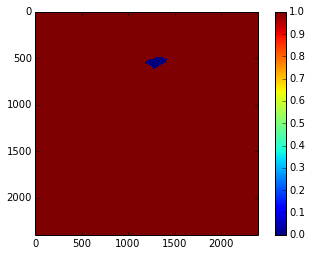

In [11]:
plt.imshow(m)
plt.colorbar()

The catchment is only a very small portion of the dataset, so you should make sure that you perform masking when you read the dataset in and only extract the area of data that you want.

#### 6.2.3.3 Discharge Data

The river discharge data are in the file [`data/delnorte.dat`](data/delnorte.dat).

If you examine the file:

In [12]:
!head -35 < data/delnorte.dat

# ---------------------------------- WARNING ----------------------------------------
# The data you have obtained from this automated U.S. Geological Survey database
# have not received Director's approval and as such are provisional and subject to
# revision.  The data are released on the condition that neither the USGS nor the
# United States Government may be held liable for any damages resulting from its use.
# Additional info: http://waterdata.usgs.gov/nwis/help/?provisional
#
# File-format description:  http://waterdata.usgs.gov/nwis/?tab_delimited_format_info
# Automated-retrieval info: http://waterdata.usgs.gov/nwis/?automated_retrieval_info
#
# Contact:   gs-w_support_nwisweb@usgs.gov
# retrieved: 2011-09-30 09:35:31 EDT       (caww02)
#
# Data for the following 1 site(s) are contained in this file
#    USGS 08220000 RIO GRANDE NEAR DEL NORTE, CO
# -----------------------------------------------------------------------------------
#
# Data provided for site 08220000
#    DD p

you will see comment lines that start with `#`, followed by data lines.

The easiest way to read these data would be to use:



In [13]:
file = 'data/delnorte.dat'
data = np.loadtxt(file,usecols=(2,3),unpack=True,dtype=str)

In [14]:
# so you have the dates in
data[0]

array(['2000-01-01', '2000-01-02', '2000-01-03', ..., '2010-12-29',
       '2010-12-30', '2010-12-31'], 
      dtype='|S10')

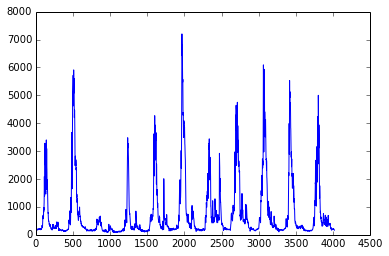

In [15]:
# and the stream flow in data[1]
plt.plot(data[1].astype(float))

You will need to convert the date field (i.e. the data in `data[0]`) into the day of year.

This is readily accomplished using `datetime`:

In [16]:
import datetime
# transform the first one
ds = np.array(data[0][0].split('-')).astype(int)
print ds
year,doy = datetime.datetime(ds[0],ds[1],ds[2]).strftime('%Y %j').split()
print year,doy

[2000    1    1]
2000 001


#### 6.2.3.4 Temperature data

We can directly access temperature data from [here](http://ccc.atmos.colostate.edu/cgi-bin/dlydb.pl?yrbeg=2000&yrend=2020&station=52184+DEL+NORTE&proc=2+-+List+Format+%28see+docs%29).

The format of [`delNorteT.dat`](files/data/delNorteT.dat) is given here.

The first three fields are date fields (`YEAR`, `MONTH` and `DAY`), followed by `TMAX`, `TMIN`, `PRCP`, `SNOW`, `SNDP`.

You should read in the temperature data for the days and years that you want. 

For temperature, you might take a **mean of TMAX and TMIN**. 

**Note that these are in Fahrenheit. You should convert them to Celcius.**

Note also that there are missing data (values `9998` and `9999`). You will need to filter these and interpolate the data in some way. A median might be a good approach, but any interpolation will suffice.

With that processing then, you should have a dataset, Temperature that will look something like (in cyan, for the year 2005):

![](files/images/temperature.png)

## 6.3 Coursework

You need to submit you coursework in the usual manner by the usual submission date.

You **must** work individually on this task. If you do not, it will be treated as plagiarism. By reading these instructions for this exercise, we assume that you are aware of the UCL rules on plagiarism. You can find more information on this matter in your student handbook. If in doubt about what might constitute plagiarism, ask one of the course convenors.

### 6.3.1 Summary of coursework requirements

- **Data Preparation**
  
     The first task you must complete is to produce a dataset of the proportion of HUC catchment 13010001 (Rio Grande headwaters in Colorado, USA) that is covered by snow for **two consecutive years**, along with associated datasets on temperature (in C) and river discharge at the Del Norte monitoring station. 
    
    You **may not** use data from the year 2005, as this is given to you in the illustrations above.

    The dataset you produce must have a value for the mean snow cover, temperature and discharge in the catchment for every day over each year.

    Your write up **must** include fully labelled graph(s) of snow cover, temperature and discharge for the catchment for each year (with units as appropriate), along with some summary statistics (e.g. mean or median, minimum, maximum, and the timing of these). 
    
    You **must** provide evidence of how you got these data (i.e. the code and commands you ran to produce the data).
    
    
    
- **Modelling**

    You will have prepared two years of data above. Use one of these years to calibrate the (snowmelt) hydrological model (described below) and one year to test it. 
    
    The model parameter estimate *must* be objective (i.e. you can't just arbitrarily choose a set) and ideally optimal, and you *must* state the equation of the cost function you will try to minimise and explain the approach used.
    
    You **must** state the values of the model parameters that you have estimated and show evidence for how you went about calculating them. Ideally, you should also state the uncertainty in these parameter estimates (not critical to pass this section though).
    
    You **must** quantify the goodness of fit between your measured flow data and that produced by your model, booth for the calibration exercise and the validation.
    

### 6.3.2 Summary of Advice

The first task involves pulling datasets from different sources. No individual part of that should be too difficult, but you must put this together from the material we have done so far. It is more a question of organisation then.

Perhaps think first about where you want to end up with on this (the 'output'). This might for example be a dictionary with keys `temp`, `doy`, `snow` and `flow`, where each of these would be an array with 365 values (or 366 in a leap year).

Then consider the datasets you have: these are: (i) a stack of MODIS data with daily observations; (ii) temperature data in a file; (iii) flow data in a file.

It might be a little fiddly getting the data you want from the flow and temperature data files, but its not very complicated. You will need to consider flagging invalid observations and perhaps interpolating between these.

Processing the MODIS data might take a little more thought, but it is much the same process. Again, we read the datasets in, trying to make this efficient on data size by only using the area of the vector data mask as in a previous exercise. The data reading will be very similar to reading the MODIS LAI product, but you need to work out and implement what changes are necessary. As advised abovem you should use the `raster_mask2()` function for creating the spatial data masks. Again, you will need to interpolate or perhaps smooth between observations, and then process the snow cover proportions to get an average over the catchment.


The second task revolves around using the model that we have developed above in the function `model_accum()`. You have been through previous examples in Python where you attempt to estimate some model parameters given an initial estimate of the parameters and some cost function to be minimised. Solving the model calibration part of problem should follow those same lines then. Testing (validation) should be easy enough. Don't forget to include the estimated parameters (and other relevant information, e.g. your initial estimate, uncertainties if available) in your write up.

There is quite a lot of data presentation here, and you need to provide *evidence* that you have done the task. Make sure you use images (e.g. of snow cover varying), graphs (e.g. modelled and predicted flow, etc.), and tables (e.g. model parameter estimates) throughout, as appropriate.

If, for some reason, you are unable to complete the first part of the practical, you should submit what you can for that first part, and continue with calibrating the model using the 2005 dataset that we used above. This would be far from ideal as you would not have completed the required elements for either part in that case, but it would generall be better than not submitting anything.

### 6.3.3 Further advice

There is plenty of scope here for going beyond the basic requirements, if you get time and are interested (and/or want a higher mark!).

You will be given credit for all additional work included in the write up, **once you have achieved the basic requirements**. So, there is no point (i.e. you will not get credit for) going off on all sorts of interesting lines of exploration here *unless* you have first completed the core task.

### 6.3.4 Structure of the Report

The required elements of the report are:

```

    Introduction (5%)
    Data Preparation (45%)
    Modelling (45%)
    Discussion/Conclusions (5%)
```

The figures in brackets indicate the percentage of marks that we will award for each section of the report.

#### Introduction (5%)

This should be of around 2-3 pages.

It should introduce the purpose of the study, being at a base level, ‘to build and calibrate a snow/hydrological model in Python’.

It should provide some background to building models of this sort (their purpose/role) and include some review of the types of models that might be built, with reference to the literature (journals).

A pass mark for this section will describe and explain the purpose of the study and examine some of the context to such modelling, with appropriate literature being cited. Higher or lower marks will depend on the depth that this goes into and the clarity of expression.


#### Data Preparation (45%)

This should contain around 3-4 pages of text, other than codes, figures and tables.

For a pass mark in this section, you must :

- introduce the study site, giving general site characteristics, with appropriate figures. 
- provide an overview of the data used in the study (snow cover, temperature, flow data) and produce visualisations of the data you are using (images, graphs, tables as appropriate) alongside appropriate summary statistics.
- fully demonstrate how you got these data to this point of processing -- i.e. submit appropriate Python codes and/or unix commands that when run in the sequence you describe would produce the data you have described.

The weighting here on the study site description is 5% and on the rest, 40%.

You can obtain higher marks here by going beyond the basics in your approaches to the data or modelling. You still need to demonstrate that you have done the core 'pass' material.


#### Modelling

This should contain around 3-4 pages of text, other than codes, figures and tables.

For a pass mark in this section, you must :

- provide an overview of the model that is constructed here, explaining the role of each parameter.
- explain the way in which model calibration and validation is to be undertaken.
- provide an overview of results of the calibration and validation along with relevant visualisations (images, graphs, tables as appropriate).
- fully demonstrate how you got these results -- i.e. submit appropriate Python codes and/or unix commands that when run in the sequence you describe would produce the results you have described.

The weighting here is 5% for the model description and on the rest, 40%.

For a mildly improved mark, you should examine and discuss the model assumptions in the context of any modelling literature you looked at in the Introduction. For a significantly improved mark, you could try improving the model. 

#### Discussion and Conclusions

This section should be around 2 pages. It should provide a discussion and analysis of your results and you should draw appropriate conclusions from these.

You can also use this section to critique the model/data/methods, and suggest ways that you would improve things. If you do this, you must give some indication of how that would be achieved. You will get no credit for simply saying ‘next time I would make the code more efficient’, for example.

Very good/excellent marks would normally require you to cite appropriate literature.

A sufficient effort for a pass would make a reasonable effort at discussing these results in the context of some literature and draw a few (non trivial) conclusions from the study.

### 6.3.5 Computer Code

#### General requirements

You will obviously need to submit computer codes as part of this assessment. Some flexibility in the style of these codes is to be expected. For example, some might write a class that encompasses the functionality for all tasks. Some poeple might have multiple versions of codes with different functionality. All of these, and other reasonable variations are allowed.

All codes needed to demonstrate that you have performed the core tasks are required to be included in the submission. You should include all codes that you make use of in the main body of the text in the main body. Any other codes that you want to refer to (e.g. something you tried out as an enhancement and didn’t quite get there) you can include in appendices.

All codes should be well-commented. Part of the marks you get for code will depend on the adequacy of the commenting.

#### Degree of original work required and plagiarism

If you use a piece of code verbatim that you have taken from the course pages or any other source, **you must acknowledge this** in comments in your text. **Not to do so is plagiarism**. Where you have taken some part (e.g. a few lines) of someone else’s code, **you should also indicate this**. If some of your code is heavily based on code from elsewhere, **you must also indicate that**.

Some examples. You may recognise this snippet of code from above.

The first example is guilty of strong plagiarism, it does not seek to acknowledge the source of this code, even though it is just a direct copy, pasted into a method called `model()`:

In [17]:
def model(tempThresh=9.0,K=2000.0,p=0.96):
    '''need to comment this further ...

    '''
    import numpy as np
    meltDays = np.where(temperature > tempThresh)[0]
    accum = snowProportion*0.
    for d in meltDays:
        water = K * snowProportion[d]
        n = np.arange(len(snowProportion)) - d
        m = p ** n
        m[np.where(n<0)]=0
        accum += m * water
    return accum

This is **not** acceptable.

This should probably be something along the lines of:

In [18]:
def model(tempThresh=9.0,K=2000.0,p=0.96):
    '''need to comment this further ...

    This code is taken directly from
    "Modelling delay in a hydrological network"
    by P. Lewis http://www2.geog.ucl.ac.uk/~plewis/geogg122/DelNorte.html
    and wrapped into a method.
    '''
    # my code: make sure numpy is imported
    import numpy as np

    # code below verbatim from Lewis
    meltDays = np.where(temperature > tempThresh)[0]
    accum = snowProportion*0.
    for d in meltDays:
        water = K * snowProportion[d]
        n = np.arange(len(snowProportion)) - d
        m = p ** n
        m[np.where(n<0)]=0
        accum += m * water
    # my code: return accumulator
    return accum

Now, we acknowledge that this is in essence a direct copy of someone else’s code, and clearly state this. We do also show that we have added some new lines to the code, and that we have wrapped this into a method.

In the next example, we have seen that the way m is generated is in fact rather inefficient, and have re-structured the code. It is partially developed from the original code, and acknowledges this:

In [19]:
def model(tempThresh=9.0,K=2000.0,p=0.96):
    '''need to comment this further ...

    This code after the model developed in
    "Modelling delay in a hydrological network"
    by P. Lewis
    http://www2.geog.ucl.ac.uk/~plewis/geogg122/DelNorte.html

    My modifications have been to make the filtering more efficient.
    '''
    # my code: make sure numpy is imported
    import numpy as np

    # code below verbatim from Lewis unless otherwise indicated
    meltDays = np.where(temperature > tempThresh)[0]
    accum = snowProportion*0.

    # my code: pull the filter block out of the loop
    n = np.arange(len(snowProportion))
    m = p ** n

    for d in meltDays:
        water = K * snowProportion[d]

        # my code: shift the filter on by one day
        # ...do something clever to shift it on by one day

        accum += m * water
    # my code: return accumulator
    return accum

This example makes it clear that significant modifications have been made to the code structure (and probably to its efficiency) although the basic model and looping comes from an existing piece of code. It clearly highlights what the actual modifications have been. Note that this is not a working example!!

Although you are supposed to do this piece of work on your own, there might be some circumstances under which someone has significantly helped you to develop the code (e.g. written the main part of it for you & you’ve just copied that with some minor modifications). You **must** acknowledge in your code comments if this has happened. On the whole though, this should not occur, as you **must** complete this work on your own.

If you take a piece of code from somewhere else and all you do is change the variable names and/or other cosmetic changes, you **must** acknowledge the source of the original code (with a URL if available).

Plagiarism in coding is a tricky issue. One reason for that is that often the best way to learn something like this is to find an example that someone else has written and adapt that to your purposes. Equally, if someone has written some tool/library to do what you want to do, it would generally not be worthwhile for you to write your own but to concentrate on using that to achieve something new. Even in general code writing (i.e. when not submitting it as part of your assessment) you and anyone else who ever has to read your code would find it of value to make reference to where you found the material to base what you did on. The key issue to bear in mind in this work, as it is submitted ‘as your own work’ is that, to avoid being accused of plagiarism and to allow a fair assessment of what you have done, you must clearly acknowledge which parts of it are your own, and the degree to which you could claim them to be your own.

For example, based on ... is absolutely fine, and you would certainly be given credit for what you have done. In many circumstances ‘taken verbatim from ...’ would also be fine (provided it is acknowledged) but then you would be given credit for what you had done with the code that you had taken from elsewhere (e.g. you find some elegant way of doing the graphs that someone has written and you make use of it for presenting your results).

The difference between what you submit here and the code you might write if this were not a piece submitted for assessment is that you the vast majority of the credit you will gain for the code will be based on the degree to which you demonstrate that you can write code to achieve the required tasks. There would obviously be some credit for taking codes from the coursenotes and bolting them together into something that achieves the overall aim: provided that worked, and you had commented it adequately and acknowledge what the extent of your efforts had been, you should be able to achieve a pass in that component of the work. If there was no original input other than vbolting pieces of existing code together though, you be unlikely to achieve more than a pass. If you get less than a pass in another component of the coursework, that then puts you in danger of an overall fail.

Provided you achieve the core tasks, the more original work that you do/show (that is of good quality), the higher the mark you will get. Once you have achieved the core tasks, even if you try something and don’t quite achieve it, is is probably worth including, as you may get marks for what you have done (or that fact that it was a good or interesting thing to try to do).

#### Documentation

Note: All methods/functions and classes must be documented for the code to be adequate. Generally, this will contain:

   - some text on the purpose of the method (/function/class)

   - some text describing the inputs and outputs, including reference to any relevant details such as datatype, shape etc where such things are of relevance to understanding the code.

   - some text on keywords, e.g.:

In [20]:
def complex(real=0.0, imag=0.0):
    """Form a complex number.

    Keyword arguments:
    real -- the real part (default 0.0)
    imag -- the imaginary part (default 0.0)

    Example taken verbatim from:
    http://www.python.org/dev/peps/pep-0257/
    """
    if imag == 0.0 and real == 0.0: return complex_zero


You should look at the [document on good docstring conventions](http://www.python.org/dev/peps/pep-0257/) when considering how to document methods, classes etc.

To demonstrate your documentation, you **must** include the help text generated by your code after you include the code. e.g.:

In [21]:
def print_something(this,stderr=False):
    '''This does something.

    Keyword arguments:
    stderr -- set to True to print to stderr (default False)
    '''

    if stderr:
        # import sys.stderr
        from sys import stderr

        # print to stderr channel, converting this to str
        print >> stderr,str(this)

        # job done, return
        return

    # print to stdout, converting this to str
    print str(this)

    return


Then the help text would be:

In [22]:
help(print_something)

Help on function print_something in module __main__:

print_something(this, stderr=False)
    This does something.
    
    Keyword arguments:
    stderr -- set to True to print to stderr (default False)



The above example represents a ‘good’ level of commenting as the code broadly adheres to the style suggestions and most of the major features are covered. It is not quite ‘very good/excellent’ as the description of the purpose of the method (rather important) is trivial and it fails to describe the input this in any way. An excellent piece would do all of these things, and might well tell us about any dependencies (e.g. requires sys if stderr set to True).

An inadequate example would be:

In [23]:
def print_something(this,stderr=False):
    '''This prints something'''
    if stderr:
        from sys import stderr
        print >> stderr,str(this)
        return
    print str(this)

It is inadequate because it still only has a trivial description of the purpose of the method, it tells us nothing about inputs/outputs and there is no commenting inside the method.

#### Word limit

There is no word limit per se on the computer codes, though as with all writing, you should try to be succint rather than overly verbose.

#### Code style

A good to excellent piece of code would take into account issues raised in the [style guide](http://www.python.org/dev/peps/pep-0008/). The ‘degree of excellence’ would depend on how well you take those points on board.